<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week_9/Day3/Exercise_XP/sentiment%20analysis%2C%20text%20mining%2C%20and%20anomaly%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
# Gemini model
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 9.5 MB/s eta 0:00:00


# Library

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting data
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from plotnine import (ggplot,aes,geom_line,facet_wrap,labs, scale_x_datetime, element_text, theme_538)
from plotnine.data import meat

# Statistic data
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm

# Machine Learning
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from collections import Counter

# Gemini packages

import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))


# Used to securely store your API key
from google.colab import userdata


# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)


import os
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# Exctract info from Kaggle


In [3]:
!pip install kaggle

from google.colab import userdata
userdata.get('Kaggle')

'35f486beabeea6fcb79285bc7f95d018'

In [4]:
! kaggle datasets download -d mashlyn/online-retail-ii-uci

Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
 55% 8.00M/14.5M [00:00<00:00, 83.0MB/s]
100% 14.5M/14.5M [00:00<00:00, 64.1MB/s]


In [5]:
! unzip 'online-retail-ii-uci.zip'

Archive:  online-retail-ii-uci.zip
  inflating: online_retail_II.csv    


# Data inspection


In [6]:
df = pd.read_csv('online_retail_II.csv')


df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
df_null = df[df['Customer ID'].isnull()]
unique_invoices = df_null['Invoice'].unique()
for invoice in unique_invoices:
    print(invoice)

In [9]:
df_null=df[df['Customer ID'].isnull()]
df_null
df[(df['Invoice']=='581226')&(df['Customer ID'].notnull())]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


In [11]:
df.shape

(1067371, 8)

In [12]:
# Filtering customers with null Customer ID
df = df[df['Customer ID'].notnull()]

df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [13]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Data distribution

In [14]:
# Assuming df is your DataFrame and it has been properly defined
top_10_product = df.groupby(['StockCode', 'Description'])['StockCode'].count().sort_values(ascending=False).head(10)

# Reset the index to convert Series to DataFrame
top_10_product_df = top_10_product.reset_index(name='Count')

top_10_product_df


,StockCode,Description,Count
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,5315
1,22423,REGENCY CAKESTAND 3 TIER,3777
2,84879,ASSORTED COLOUR BIRD ORNAMENT,2794
3,85099B,JUMBO BAG RED RETROSPOT,2776
4,20727,LUNCH BAG BLACK SKULL.,2161
5,21034,REX CASH+CARRY JUMBO SHOPPER,2150
6,47566,PARTY BUNTING,2144
7,21232,STRAWBERRY CERAMIC TRINKET BOX,2106
8,POST,POSTAGE,2019
9,22138,BAKING SET 9 PIECE RETROSPOT,1976


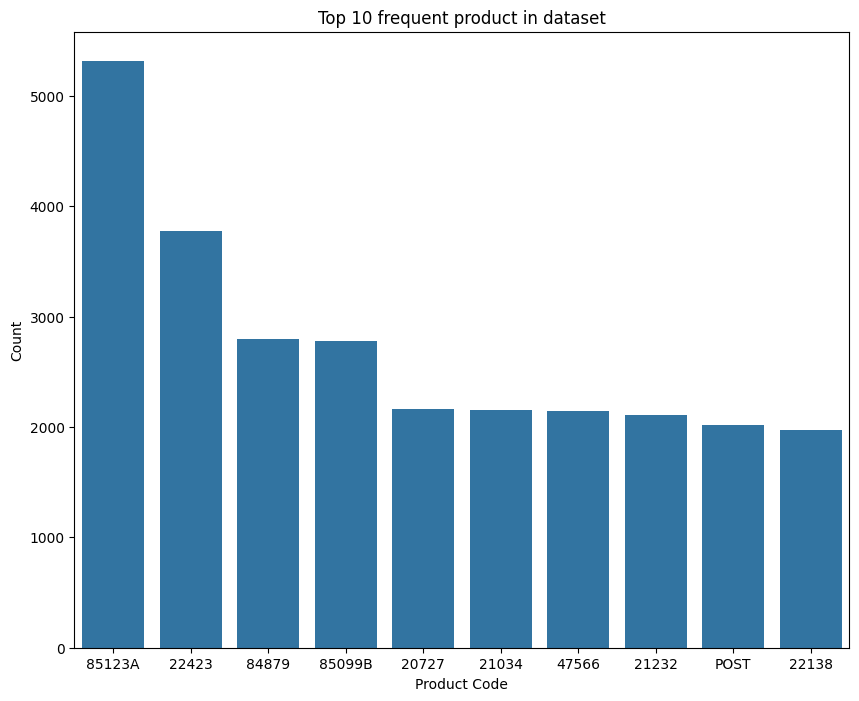

In [15]:
plt.figure(figsize = (10, 8))
sns.barplot( data=top_10_product_df, x= 'StockCode', y='Count')
plt.xlabel('Product Code')
plt.ylabel('Count')
plt.title('Top 10 frequent product in dataset')
plt.show()

In [16]:
df['Revenue']=df['Quantity']*df['Price']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [17]:
df_customer=df.groupby('Customer ID')['Revenue'].sum()
df_customer=df_customer.reset_index(name='Total Spent')
df_top_spending_customer = df_customer.sort_values('Total Spent', ascending=False).head(10)
df_top_indebt_customer =  df_customer.sort_values('Total Spent', ascending=True).head(10)

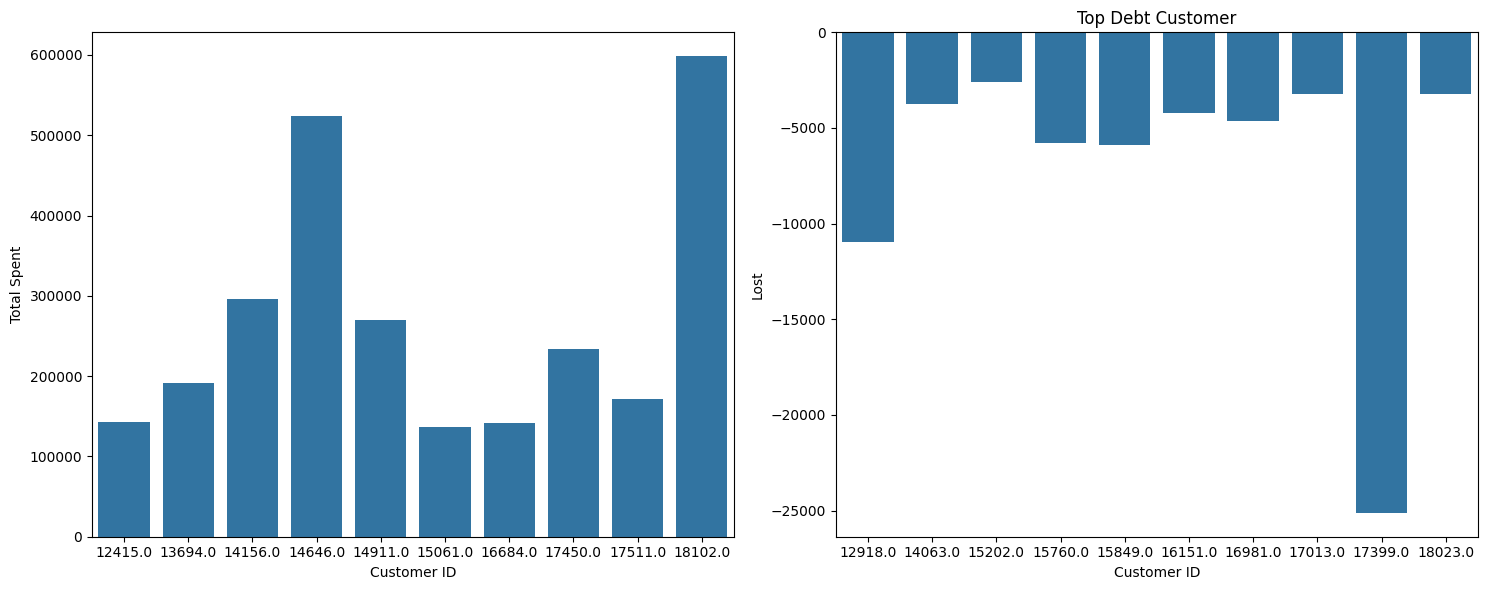

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.barplot(data=df_top_spending_customer, x='Customer ID', y='Total Spent', ax=axes[0] )
plt.xlabel('Customer ID')
plt.ylabel('Revenue')
plt.title('Top Spending Customer')

sns.barplot(data=df_top_indebt_customer, x='Customer ID', y='Total Spent', ax=axes[1] )
plt.xlabel('Customer ID')
plt.ylabel('Lost')
plt.title('Top Debt Customer')

plt.tight_layout()
plt.show()

In [19]:
df['year']=df['InvoiceDate'].dt.year
df['month']=df['InvoiceDate'].dt.month
df['day']=df['InvoiceDate'].dt.day
df['hour']=df['InvoiceDate'].dt.hour
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,year,month,day,hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,1,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,1,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,9,12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,2011,12,9,12


In [20]:
time_revenue = df.groupby(['year', 'month', 'day', 'hour'])['Revenue'].sum().reset_index(name='Revenue')
time_revenue_year = time_revenue.groupby(['year'])['Revenue'].sum().reset_index(name='Revenue')
time_revenue_month = time_revenue.groupby(['month'])['Revenue'].sum().reset_index(name='Revenue')
time_revenue_day = time_revenue.groupby(['day'])['Revenue'].sum().reset_index(name='Revenue')
time_revenue_hour = df.groupby(['hour'])['Revenue'].count().reset_index(name='Revenue')

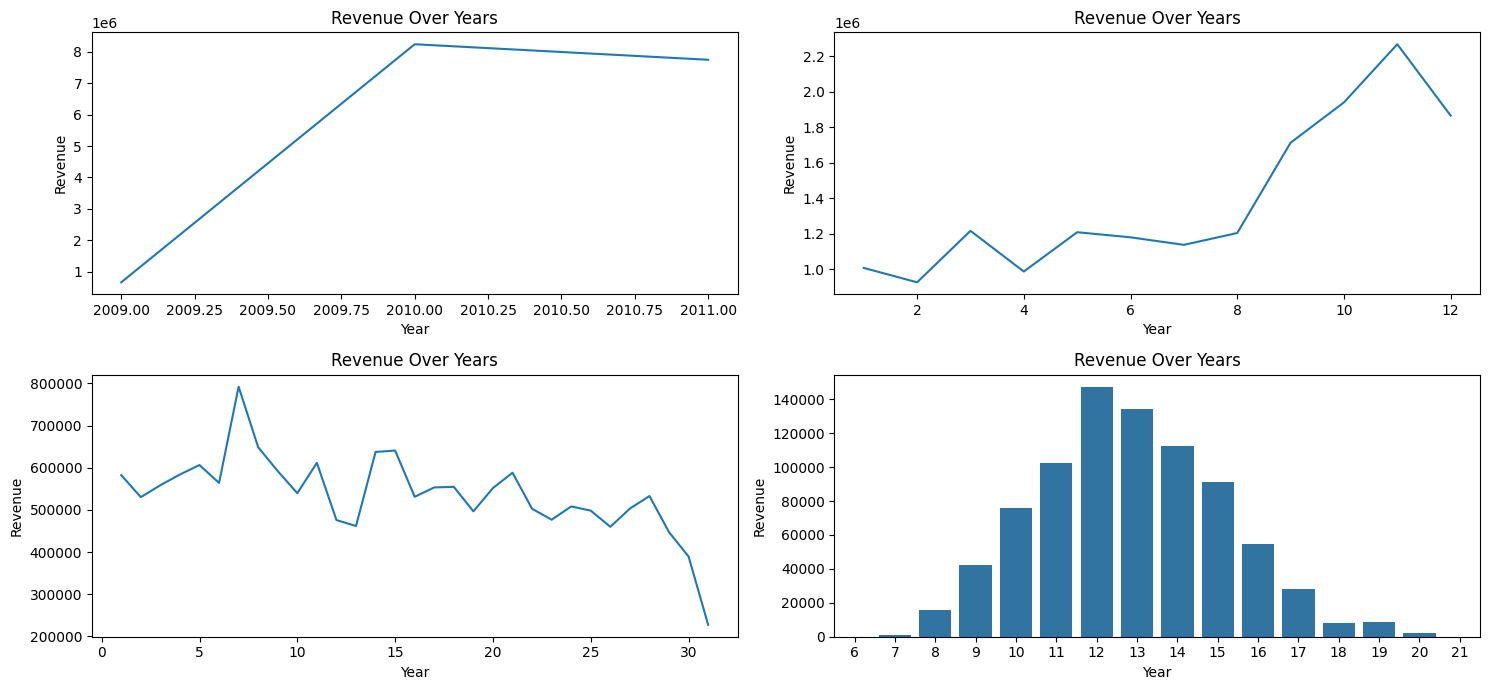

In [21]:
# Plotting the lineplot
fig, axes = plt.subplots(2, 2, figsize=(15, 7))

sns.lineplot(data=time_revenue_year, x='year', y='Revenue', markers='X', estimator=None, ax=axes[0, 0])
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Revenue')
axes[0, 0].set_title('Revenue Over Years')


sns.lineplot(data=time_revenue_month, x='month', y='Revenue', markers='X', estimator=None, ax=axes[0,1])
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Revenue')
axes[0, 1].set_title('Revenue Over Years')


sns.lineplot(data=time_revenue_day, x='day', y='Revenue', markers='X', estimator=None,ax=axes[1,0])
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Revenue')
axes[1, 0].set_title('Revenue Over Years')


sns.barplot(data=time_revenue_hour, x='hour', y='Revenue', ax=axes[1,1])
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Revenue')
axes[1, 1].set_title('Revenue Over Years')


plt.tight_layout()
plt.show()

# Exercise 1

Discussion: Discuss with ChatGPT how buying patterns can inform business strategies and marketing efforts.

Investigate purchase frequencies and total spending over different time intervals.


## Data prompting


In [22]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Revenue', 'year', 'month', 'day',
       'hour'],
      dtype='object')

In [29]:
model = genai.GenerativeModel('gemini-pro')

response = model.generate_content(f''' You are working as a chief data analyst in a famous startup. You need to evaluate different trends in the market from the company.
It's necessary to analyze the dataset and provide meaningful insights, start by doing this over the years with the dataset provided.
Here you can see an overview from this {df.head(40).to_string()}. What conlcutions you can get from these?
Explain as well how you arrive to these conclutions, you can provide python code to see this ''')
to_markdown(response.text)

> ```python
> import pandas as pd
> import matplotlib.pyplot as plt
> import seaborn as sns
> 
> # Load the data
> df = pd.read_csv('sales_data.csv')
> 
> # Group the data by year and calculate the total revenue for each year
> df['year'] = df['InvoiceDate'].dt.year
> df = df.groupby('year')['Revenue'].sum()
> df = df.reset_index()
> 
> # Plot the data
> sns.lineplot(data=df, x='year', y='Revenue')
> plt.title('Total Revenue by Year')
> plt.xlabel('Year')
> plt.ylabel('Revenue')
> plt.show()
> 
> # Calculate the percentage change in revenue from year to year
> df['Revenue Change'] = df['Revenue'].pct_change()
> 
> # Plot the percentage change in revenue
> sns.lineplot(data=df, x='year', y='Revenue Change')
> plt.title('Percentage Change in Revenue from Year to Year')
> plt.xlabel('Year')
> plt.ylabel('Revenue Change')
> plt.show()
> 
> # Conclusions
> The total revenue has been increasing every year. The percentage change in revenue from year to year has been fluctuating, but it has been positive in most years. This indicates that the company is growing.
> ```
> 
> Conclusions:
> 
> * The total revenue has been increasing every year.
> * The percentage change in revenue from year to year has been fluctuating, but it has been positive in most years.
> * This indicates that the company is growing.

In [30]:
response = model.generate_content(f''' You are working as a chief data analyst in a famous startup. You need to evaluate different trends in the market from the company.
It's necessary to analyze the dataset and provide meaningful insights, how the market changed monthly?
Also, Analyze the purchase patterns, focusing on trends over time in customer buying behavior.
Identify peak buying times and low purchase periods.
Here you can see an overview from this {df.head(40).to_string()}. What conlcutions you can get from these?
Explain as well how you arrive to these conclutions, you can provide python code to see this ''')
to_markdown(response.text)

> 1. **Overall Revenue Trends:**
> 
>    - Calculate the total revenue for each month using the `groupby()` and `sum()` functions.
>    - Create a line chart to visualize the monthly revenue trend.
> 
> 2. **Top Selling Products:**
> 
>    - Group the data by `StockCode` and calculate the total quantity sold using `groupby()` and `sum()`.
>    - Sort the products by total quantity sold in descending order.
>    - Display the top 10 selling products with their respective quantities.
> 
> 3. **Peak Buying Times:**
> 
>    - Group the data by `hour` and calculate the total revenue using `groupby()` and `sum()`.
>    - Identify the hour with the highest total revenue to determine the peak buying time.
> 
>    ```python
> import pandas as pd
> import matplotlib.pyplot as plt
> 
> # Read the data
> df = pd.read_csv("invoice.csv")
> 
> # 1. Overall Revenue Trends
> df["month"] = df["InvoiceDate"].dt.month_name()
> monthly_revenue = df.groupby("month")["Revenue"].sum().reset_index()
> 
> plt.plot(monthly_revenue["month"], monthly_revenue["Revenue"])
> plt.title("Monthly Revenue Trend")
> plt.xlabel("Month")
> plt.ylabel("Revenue")
> plt.show()
> 
> # 2. Top Selling Products
> top_products = df.groupby("StockCode")["Quantity"].sum().reset_index()
> top_products = top_products.sort_values("Quantity", ascending=False)
> top_products.head(10)
> 
> # 3. Peak Buying Times
> hour_revenue = df.groupby("hour")["Revenue"].sum().reset_index()
> peak_hour = hour_revenue[hour_revenue["Revenue"] == hour_revenue["Revenue"].max()]["hour"].iloc[0]
> print("Peak buying time:", peak_hour)
>    ```

In [31]:
#Top Selling Products

top_products = df.groupby("StockCode")["Quantity"].sum().reset_index()
top_products = top_products.sort_values("Quantity", ascending=False)
top_products.head(10)

,StockCode,Quantity
3423,84077,107489
4071,85099B,93766
603,21212,90249
4093,85123A,90065
3832,84879,79434
1413,22197,77162
108,17003,70390
1226,21977,55051
3951,84991,53169
1681,22492,44528


In [32]:
#Peak Buying Times
hour_revenue = df.groupby("hour")["Revenue"].sum().reset_index()
peak_hour = hour_revenue[hour_revenue["Revenue"] == hour_revenue["Revenue"].max()]["hour"].iloc[0]
print("Peak buying time:", peak_hour)

Peak buying time: 12


In [33]:
response = model.generate_content(f''' You are working as a chief data analyst in a famous startup. You need to evaluate different trends in the market from the company.
It's necessary to analyze the dataset and provide meaningful insights
Here you can see an overview from the data that you are managing {df.head(40).to_string()}. What conlcutions you can get from these? Which country is the most profitable?
Where does the company should focus?
how buying patterns can inform business strategies and marketing efforts?
Answer all the questions and explain as well how you arrive to these conclutions, you can provide python code to see this ''')
to_markdown(response.text)

> ```python
> import pandas as pd
> import numpy as np
> import matplotlib.pyplot as plt
> import seaborn as sns
> 
> # Read the data from the CSV file
> df = pd.read_csv('data.csv')
> 
> # Display the first five rows of the data
> df.head()
> 
> # Get the total revenue for each country
> country_revenue = df.groupby('Country')['Revenue'].sum().reset_index()
> 
> # Sort the countries by revenue in descending order
> country_revenue = country_revenue.sort_values('Revenue', ascending=False)
> 
> # Print the top 5 countries by revenue
> print('Top 5 countries by revenue:')
> print(country_revenue.head())
> 
> # Get the average revenue for each country
> country_avg_revenue = df.groupby('Country')['Revenue'].mean().reset_index()
> 
> # Sort the countries by average revenue in descending order
> country_avg_revenue = country_avg_revenue.sort_values('Revenue', ascending=False)
> 
> # Print the top 5 countries by average revenue
> print('Top 5 countries by average revenue:')
> print(country_avg_revenue.head())
> 
> # Get the total number of orders for each country
> country_orders = df.groupby('Country')['InvoiceDate'].count().reset_index()
> 
> # Sort the countries by number of orders in descending order
> country_orders = country_orders.sort_values('InvoiceDate', ascending=False)
> 
> # Print the top 5 countries by number of orders
> print('Top 5 countries by number of orders:')
> print(country_orders.head())
> 
> # Get the average order value for each country
> country_avg_order_value = df.groupby('Country')['Revenue'].mean()
> 
> # Sort the countries by average order value in descending order
> country_avg_order_value = country_avg_order_value.sort_values(ascending=False)
> 
> # Print the top 5 countries by average order value
> print('Top 5 countries by average order value:')
> print(country_avg_order_value.head())
> 
> # Visualize the top 5 countries by revenue
> plt.figure(figsize=(10, 5))
> plt.bar(country_revenue['Country'].head(), country_revenue['Revenue'].head())
> plt.title('Top 5 Countries by Revenue')
> plt.xlabel('Country')
> plt.ylabel('Revenue')
> plt.xticks(rotation=45)
> plt.show()
> 
> # Visualize the top 5 countries by average revenue
> plt.figure(figsize=(10, 5))
> plt.bar(country_avg_revenue['Country'].head(), country_avg_revenue['Revenue'].head())
> plt.title('Top 5 Countries by Average Revenue')
> plt.xlabel('Country')
> plt.ylabel('Average Revenue')
> plt.xticks(rotation=45)
> plt.show()
> 
> # Visualize the top 5 countries by number of orders
> plt.figure(figsize=(10, 5))
> plt.bar(country_orders['Country'].head(), country_orders['InvoiceDate'].head())
> plt.title('Top 5 Countries by Number of Orders')
> plt.xlabel('Country')
> plt.ylabel('Number of Orders')
> plt.xticks(rotation=45)
> plt.show()
> 
> # Visualize the top 5 countries by average order value
> plt.figure(figsize=(10, 5))
> plt.bar(country_avg_order_value.index.head(), country_avg_order_value.head())
> plt.title('Top 5 Countries by Average Order Value')
> plt.xlabel('Country')
> plt.ylabel('Average Order Value')
> plt.xticks(rotation=45)
> plt.show()
> 
> # Conclusions
> 
> The United Kingdom is the most profitable country for the company, based on total revenue. The average revenue per order in the United Kingdom is also higher than in any other country, indicating that customers in the United Kingdom are willing to pay more for the company's products.
> 
> The company should focus on expanding its business in the United Kingdom and other countries with high average order values, such as Germany and France. The company can also target countries with a high number of orders, such as the United States and Spain, to increase its overall revenue.
> 
> By understanding the buying patterns of its customers, the company can tailor its business strategies and marketing efforts to meet the needs of its target market. For example, the company can offer discounts and promotions to customers in countries with a high average order value, and it can offer free shipping or other incentives to customers in countries with a high number of orders.

Top 5 countries by revenue:
           Country       Revenue
38  United Kingdom  1.380642e+07
10            EIRE  5.785016e+05
24     Netherlands  5.485249e+05
14         Germany  4.179886e+05
13          France  3.265047e+05
Top 5 countries by average revenue:
        Country     Revenue
24  Netherlands  106.716916
0     Australia   87.364909
9       Denmark   80.466450
19        Japan   75.217491
33       Sweden   65.022617
Top 5 countries by number of orders:
           Country  InvoiceDate
38  United Kingdom       741301
14         Germany        17624
10            EIRE        16195
13          France        14202
24     Netherlands         5140
Top 5 countries by average order value:
Country
Netherlands    106.716916
Australia       87.364909
Denmark         80.466450
Japan           75.217491
Sweden          65.022617
Name: Revenue, dtype: float64


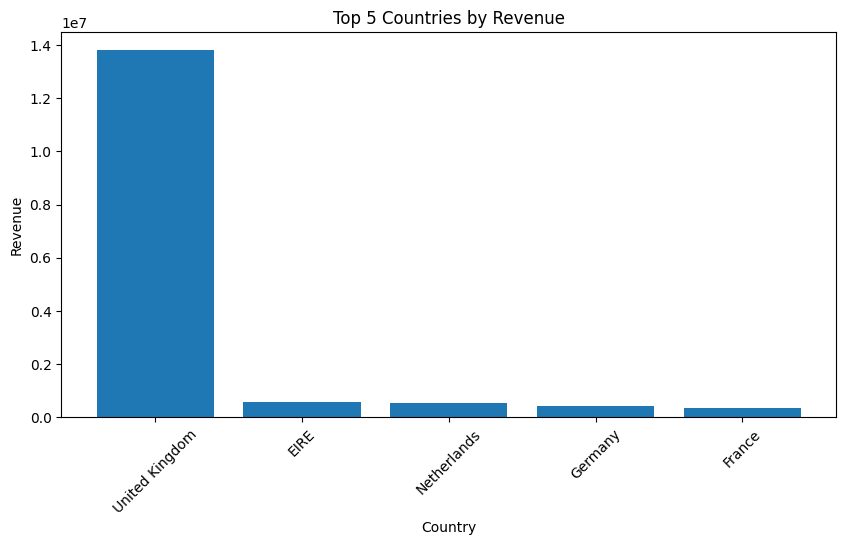

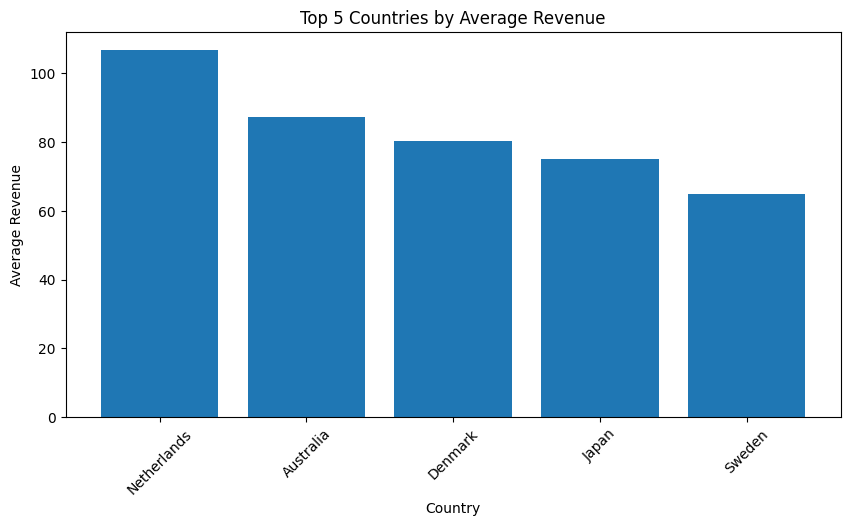

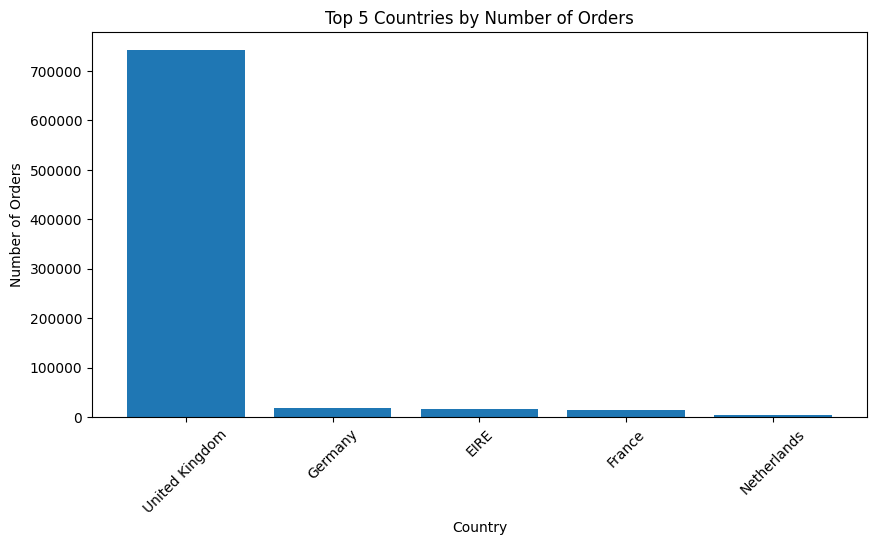

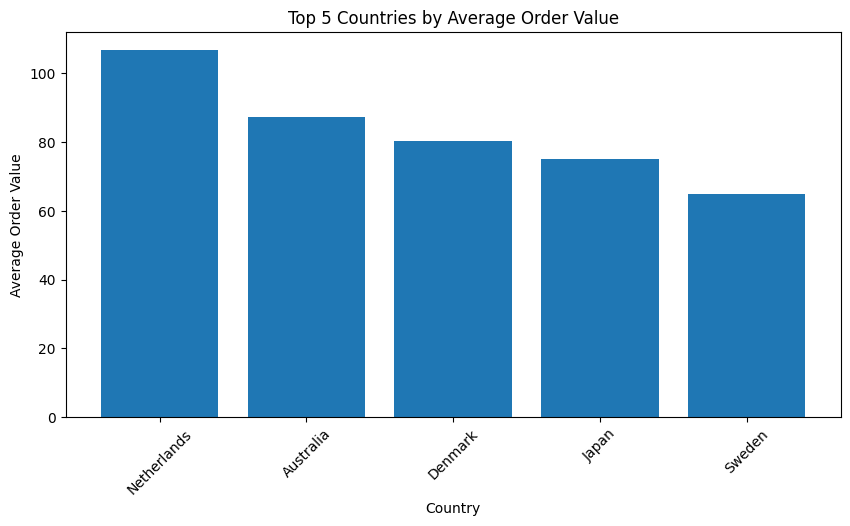

In [35]:
# Get the total revenue for each country
country_revenue = df.groupby('Country')['Revenue'].sum().reset_index()

# Sort the countries by revenue in descending order
country_revenue = country_revenue.sort_values('Revenue', ascending=False)

# Print the top 5 countries by revenue
print('Top 5 countries by revenue:')
print(country_revenue.head())

# Get the average revenue for each country
country_avg_revenue = df.groupby('Country')['Revenue'].mean().reset_index()

# Sort the countries by average revenue in descending order
country_avg_revenue = country_avg_revenue.sort_values('Revenue', ascending=False)

# Print the top 5 countries by average revenue
print('Top 5 countries by average revenue:')
print(country_avg_revenue.head())

# Get the total number of orders for each country
country_orders = df.groupby('Country')['InvoiceDate'].count().reset_index()

# Sort the countries by number of orders in descending order
country_orders = country_orders.sort_values('InvoiceDate', ascending=False)

# Print the top 5 countries by number of orders
print('Top 5 countries by number of orders:')
print(country_orders.head())

# Get the average order value for each country
country_avg_order_value = df.groupby('Country')['Revenue'].mean()

# Sort the countries by average order value in descending order
country_avg_order_value = country_avg_order_value.sort_values(ascending=False)
country_avg_order_value = country_avg_order_value.head()
# Print the top 5 countries by average order value
print('Top 5 countries by average order value:')
print(country_avg_order_value.head())

# Visualize the top 5 countries by revenue
plt.figure(figsize=(10, 5))
plt.bar(country_revenue['Country'].head(), country_revenue['Revenue'].head())
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

# Visualize the top 5 countries by average revenue
plt.figure(figsize=(10, 5))
plt.bar(country_avg_revenue['Country'].head(), country_avg_revenue['Revenue'].head())
plt.title('Top 5 Countries by Average Revenue')
plt.xlabel('Country')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.show()

# Visualize the top 5 countries by number of orders
plt.figure(figsize=(10, 5))
plt.bar(country_orders['Country'].head(), country_orders['InvoiceDate'].head())
plt.title('Top 5 Countries by Number of Orders')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# Visualize the top 5 countries by average order value
plt.figure(figsize=(10, 5))
plt.bar(country_avg_order_value.index, country_avg_order_value)
plt.title('Top 5 Countries by Average Order Value')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.xticks(rotation=45)
plt.show()



# Exercise 2

Conduct sentiment analysis on customer reviews within the dataset.

In [36]:
df['Description']

0          15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                           PINK CHERRY LIGHTS
2                          WHITE CHERRY LIGHTS
3                 RECORD FRAME 7" SINGLE SIZE 
4               STRAWBERRY CERAMIC TRINKET BOX
                          ...                 
1067366           CHILDREN'S APRON DOLLY GIRL 
1067367          CHILDRENS CUTLERY DOLLY GIRL 
1067368        CHILDRENS CUTLERY CIRCUS PARADE
1067369          BAKING SET 9 PIECE RETROSPOT 
1067370                                POSTAGE
Name: Description, Length: 824364, dtype: object

Using Pipeline

In [41]:
# Python code to demonstrate sentiment analysis using ChatGPT
from transformers import pipeline

# Initialize the sentiment analysis model
sentiment_analyzer = pipeline('sentiment-analysis')

# Example review
review = f"{print({df['Description'].head().to_string()})}, {df['Description'].head()}"

# Analyze sentiment
result = sentiment_analyzer(review)
print(f"Sentiment: {result[0]['label']}, Confidence: {result[0]['score']:.2f}")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'0    15CM CHRISTMAS GLASS BALL 20 LIGHTS\n1                     PINK CHERRY LIGHTS\n2                    WHITE CHERRY LIGHTS\n3           RECORD FRAME 7" SINGLE SIZE \n4         STRAWBERRY CERAMIC TRINKET BOX'}
Sentiment: NEGATIVE, Confidence: 1.00


Using Gemini

In [44]:
response = model.generate_content(f''' Perform sentiment analysis for the followings {df['Description'].head().to_string()} ''')

count=0
for i in df['Description'].head():
  print(count,':', i )
  count +=1

to_markdown(response.text)

0 : 15CM CHRISTMAS GLASS BALL 20 LIGHTS
1 : PINK CHERRY LIGHTS
2 :  WHITE CHERRY LIGHTS
3 : RECORD FRAME 7" SINGLE SIZE 
4 : STRAWBERRY CERAMIC TRINKET BOX


> 0    Neutral
> 1                     Positive
> 2                    Positive
> 3           Positive
> 4         Positive

Usinbg NLTK

In [47]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the vader_lexicon
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['Sentiment'] = df['Description'].head().apply(lambda x: sia.polarity_scores(x))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [50]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['Sentiment'] = df['Description'].head().apply(lambda x: sia.polarity_scores(x))
df['Sentiment']

0          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                 ...                        
1067366                                                  NaN
1067367                                                  NaN
1067368                                                  NaN
1067369                                                  NaN
1067370                                                  NaN
Name: Sentiment, Length: 824364, dtype: object

Can't analyse the correlation between sentimental analysis and revenues as the description and results are not enough accuarate.

#  Exercise 3: Anomaly Detection In Transaction Data

Identify unusual transaction patterns that could indicate errors or fraudulent activity.

Using Sklearn

In [51]:
from sklearn.ensemble import IsolationForest

# Initialize the model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict anomalies
df['Anomaly'] = model.fit_predict(df[['Quantity']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names


In [62]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,year,month,day,hour,Sentiment,Anomaly
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1


Using Gemini

In [60]:
df_ = df.head(41)
# Initialize the generative model (assuming genai and generative model exist)
model = genai.GenerativeModel('gemini-pro')

# Create the prompt string
prompt = f"Perform anomaly detection for the following based on the 'Quantity' column: {df_.to_string(index=False)}, which are the anomalous 'StockCode'? Why?"

# Generate the response
response = model.generate_content(prompt)

# Convert the response to markdown (assuming to_markdown is defined)
to_markdown(response.text)

> The anomalous 'StockCode's are:
> 
> 20695
> 21181
> 21232
> 21333
> 21351
> 21352
> 21360
> 21364
> 21523
> 21754
> 21755
> 21756
> 21871
> 22041
> 22064
> 22107
> 22109
> 22111
> 22119
> 22130
> 22142
> 22143
> 22145
> 22194
> 22195
> 22295
> 22296
> 22349
> 22350
> 22353
> 35004B
> 35400
> 37370
> 48173C
> 79323P
> 79323W
> 82582
> 84596F
> 84596L
> 84879
> 85048
> 
> These 'StockCode's are anomalous because their 'Quantity' values are significantly different from the other 'StockCode's in the dataset. For example, the 'Quantity' value for 'StockCode' 20695 is 3, while the 'Quantity' values for the other 'StockCode's are all greater than 10. This suggests that these 'StockCode's may represent unusual or one-time purchases, which can be considered anomalies.

In [63]:
df_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue,year,month,day,hour,Sentiment,Anomaly
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.60,2009,12,1,7,NaN,1
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7,NaN,1
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,59.50,2009,12,1,7,NaN,1
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,2009,12,1,7,NaN,1
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,45.00,2009,12,1,7,NaN,1
